In [1]:
import requests
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import quandl
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
quandl.ApiConfig.api_key = "hM2Bkaxjh6gcuZjd7Djx"

In [3]:
url = "http://www.coingecko.com"

In [4]:
page = requests.get(url)

In [5]:
page

<Response [200]>

In [6]:
text = page.text

In [7]:
len(text)

2534123

In [8]:
text[:100]

'<!DOCTYPE html>\n<html>\n<head>\n<meta charset="utf-8">\n<meta http-equiv="X-UA-Compatible" content="IE='

In [9]:
base = "http://api.coingecko.com/api/v3"

In [10]:
url = base + "/coins/list"

In [11]:
result = requests.get(url)

In [12]:
result

<Response [200]>

In [13]:
j = result.json()

In [14]:
type(j)

list

In [15]:
j[:3]

[{'id': '01coin', 'symbol': 'zoc', 'name': '01coin'},
 {'id': '02-token', 'symbol': 'o2t', 'name': 'O2 Token'},
 {'id': '0chain', 'symbol': 'zcn', 'name': '0chain'}]

In [16]:
j[2]['name']

'0chain'

In [17]:
len(j)

3859

In [18]:
df = pd.DataFrame(j)

In [19]:
df.head(10)

,id,name,symbol
0,01coin,01coin,zoc
1,02-token,O2 Token,o2t
2,0chain,0chain,zcn
3,0x,0x,zrx
4,0xcert,0xcert,zxc
5,10m-token,10M Token,10mt
6,1337,1337,1337
7,1apayment,1APayment,1ap
8,1sg,1SG,1sg
9,1world,1World,1wo


In [20]:
df.shape

(3859, 3)

# We start by scraping the web to retrieve the Bitcoin prices for the last year: 

In [21]:
url = base + "/coins/bitcoin/market_chart?vs_currency=usd&days=100"

In [22]:
result = requests.get(url)

In [23]:
result

<Response [200]>

In [24]:
j = result.json()

In [25]:
type(j)

dict

In [26]:
len(j)

3

In [27]:
btc = pd.DataFrame(j['prices'], columns = ['date', 'price'])

In [28]:
btc.head(10)

,date,price
0,1539820800000,6635.741832
1,1539907200000,6517.511088
2,1539993600000,6483.827769
3,1540080000000,6532.678750
4,1540166400000,6529.670021
5,1540252800000,6512.589059
6,1540339200000,6472.799661
7,1540425600000,6481.443590
8,1540512000000,6458.191522
9,1540598400000,6468.826425


Next we take some steps in order to get timestamps rounded to the nearest hour:

In [29]:
btc['date'] = (btc['date'] / 3600000).round() * 3600000

In [30]:
btc.head()

,date,price
0,1.539821e+12,6635.741832
1,1.539907e+12,6517.511088
2,1.539994e+12,6483.827769
3,1.540080e+12,6532.678750
4,1.540166e+12,6529.670021


Then we convert this to date and time using the pandas function:

In [31]:
btc['date'] = pd.to_datetime(btc['date'] * 1000000)

In [32]:
btc.head()

,date,price
0,2018-10-18,6635.741832
1,2018-10-19,6517.511088
2,2018-10-20,6483.827769
3,2018-10-21,6532.678750
4,2018-10-22,6529.670021


In [33]:
btc.set_index('date', inplace=True) # sets the date to the index

In [34]:
btc.head(10)

,price
date,
2018-10-18,6635.741832
2018-10-19,6517.511088
2018-10-20,6483.827769
2018-10-21,6532.678750
2018-10-22,6529.670021
2018-10-23,6512.589059
2018-10-24,6472.799661
2018-10-25,6481.443590
2018-10-26,6458.191522


Next, we plot the time series:

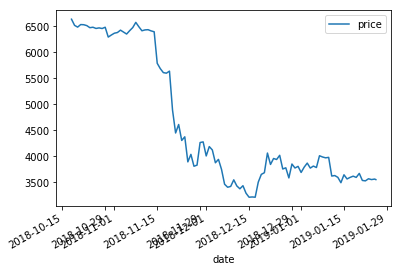

In [35]:
btc.plot.line()

### Retrieve some info from Quandl - Blockchain activity (total transcations per day):

In [36]:
quandl_bc = quandl.get("BCHAIN/MWNTD", start_date='2018-10-17', end_date='2019-01-25', authtoken="hM2Bkaxjh6gcuZjd7Djx")

In [37]:
quandl_bc['day-2'] = quandl_bc['Value'].shift(2)

In [38]:
quandl_bc.dropna(inplace=True)

In [39]:
quandl_bc.head()

,Value,day-2
Date,,
2018-10-19,66857.0,66359.0
2018-10-20,68839.0,69676.0
2018-10-21,57877.0,66857.0
2018-10-22,53274.0,68839.0
2018-10-23,69425.0,57877.0


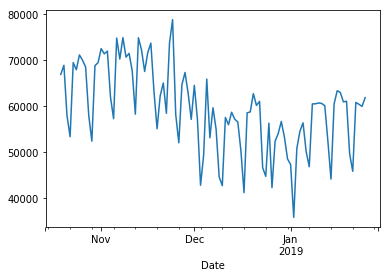

In [40]:
quandl_bc['Value'].plot.line()

In [41]:
quandl_bc.shape

(99, 2)

## To retrieve 10 currencies from CoinGecko and plot their time series together:

In [42]:
cur = ['bitcoin', 'bitcoin-cash', 'litecoin', 'dogecoin', 'ethereum', 'basic-attention-token', 'neo', 'ripple', 'stellar', 'cardano']

In [43]:
df10 = pd.DataFrame()
for c in cur:
    url = base + f'/coins/{c}/market_chart?vs_currency=usd&days=100'
    result = requests.get(url)
    j = result.json()
    df = pd.DataFrame(j['prices'], columns = ['date', c])
    z = (df['date'] / 3600000).round() * 3600000 * 1000000
    df['date'] = pd.to_datetime(z)
    df.set_index('date', inplace=True)
    df10[c] = df[c]

In [44]:
df10.head(10)

,bitcoin,bitcoin-cash,litecoin,dogecoin,ethereum,basic-attention-token,neo,ripple,stellar,cardano
date,,,,,,,,,,
2018-10-18,6635.741832,458.140703,54.766110,0.004686,211.082693,0.217289,17.026798,0.475898,0.245117,0.078768
2018-10-19,6517.511088,441.858937,52.839907,0.004447,204.313049,0.209503,16.706131,0.461450,0.245631,0.075799
2018-10-20,6483.827769,445.017301,53.414534,0.004543,203.976263,0.236869,16.650159,0.457672,0.245948,0.076412
2018-10-21,6532.678750,452.896201,53.927454,0.004615,206.882099,0.235765,16.842330,0.464206,0.247179,0.077267
2018-10-22,6529.670021,453.019029,53.247423,0.004557,206.309827,0.262417,16.703225,0.460830,0.244539,0.076538
2018-10-23,6512.589059,452.609698,52.704686,0.004477,205.037755,0.270981,16.933534,0.456776,0.245541,0.076528
2018-10-24,6472.799661,445.403304,52.713733,0.004217,204.083946,0.252658,16.704700,0.463954,0.243715,0.075001
2018-10-25,6481.443590,443.708558,52.531368,0.003944,203.522199,0.274249,16.775400,0.458798,0.238868,0.074681
2018-10-26,6458.191522,442.490442,52.285844,0.003735,202.353023,0.267396,16.603520,0.460452,0.236837,0.074324


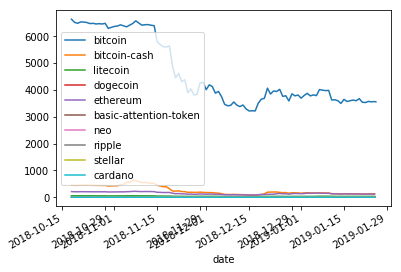

In [45]:
df10.plot()

## Plot a rolling average (for Bitcoin):

In [46]:
btc.head()

,price
date,
2018-10-18,6635.741832
2018-10-19,6517.511088
2018-10-20,6483.827769
2018-10-21,6532.678750
2018-10-22,6529.670021


In [47]:
price = btc[['price']]

In [48]:
roll = price.rolling(10)

In [49]:
means = roll.mean()

In [50]:
means.head(15)

,price
date,
2018-10-18,NaN
2018-10-19,NaN
2018-10-20,NaN
2018-10-21,NaN
2018-10-22,NaN
2018-10-23,NaN
2018-10-24,NaN
2018-10-25,NaN
2018-10-26,NaN


Append this to our DataFrame:

In [51]:
price['roll10'] = means

In [52]:
price.tail(15)

,price,roll10
date,,
2019-01-12 00:00:00,3632.849306,3846.697694
2019-01-13 00:00:00,3598.436347,3819.324110
2019-01-14 00:00:00,3495.832311,3791.254761
2019-01-15 00:00:00,3648.048286,3774.532781
2019-01-16 00:00:00,3567.801243,3752.582120
2019-01-17 00:00:00,3597.647323,3710.994843
2019-01-18 00:00:00,3620.981281,3674.126099
2019-01-19 00:00:00,3597.793252,3636.546299
2019-01-20 00:00:00,3674.587271,3605.782435


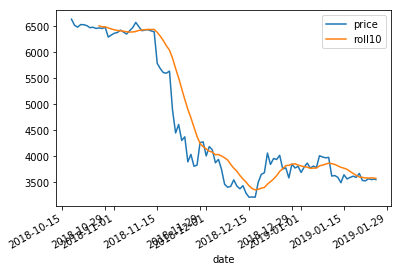

In [53]:
price.plot()

### Plot an autocorrelation function:

In [54]:
btc.head()

,price
date,
2018-10-18,6635.741832
2018-10-19,6517.511088
2018-10-20,6483.827769
2018-10-21,6532.678750
2018-10-22,6529.670021


In [55]:
autocorr = pd.DataFrame({'acf': acf(btc), 'pacf': pacf(btc)})
autocorr.head()

C:\Users\Dave\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


,acf,pacf
0,1.000000,1.000000
1,0.973418,0.983152
2,0.949364,0.058549
3,0.923597,-0.065023
4,0.895277,-0.106774


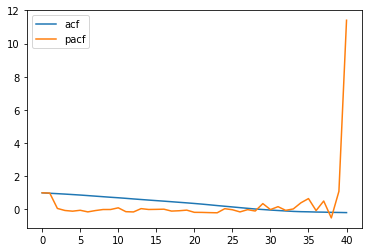

In [56]:
autocorr.plot()

In [57]:
df = df10.copy()
for c in cur:
    df[f'{c}_day-1'] = df[f'{c}'].shift(1)
    df[f'{c}_day-2'] = df[f'{c}'].shift(2) # give price 1 and 2 days ago for each currency (including Bitcoin)
df.head()

,bitcoin,bitcoin-cash,litecoin,dogecoin,ethereum,basic-attention-token,neo,ripple,stellar,cardano,...,basic-attention-token_day-1,basic-attention-token_day-2,neo_day-1,neo_day-2,ripple_day-1,ripple_day-2,stellar_day-1,stellar_day-2,cardano_day-1,cardano_day-2
date,,,,,,,,,,,,,,,,,,,,,
2018-10-18,6635.741832,458.140703,54.766110,0.004686,211.082693,0.217289,17.026798,0.475898,0.245117,0.078768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-19,6517.511088,441.858937,52.839907,0.004447,204.313049,0.209503,16.706131,0.461450,0.245631,0.075799,...,0.217289,NaN,17.026798,NaN,0.475898,NaN,0.245117,NaN,0.078768,NaN
2018-10-20,6483.827769,445.017301,53.414534,0.004543,203.976263,0.236869,16.650159,0.457672,0.245948,0.076412,...,0.209503,0.217289,16.706131,17.026798,0.461450,0.475898,0.245631,0.245117,0.075799,0.078768
2018-10-21,6532.678750,452.896201,53.927454,0.004615,206.882099,0.235765,16.842330,0.464206,0.247179,0.077267,...,0.236869,0.209503,16.650159,16.706131,0.457672,0.461450,0.245948,0.245631,0.076412,0.075799
2018-10-22,6529.670021,453.019029,53.247423,0.004557,206.309827,0.262417,16.703225,0.460830,0.244539,0.076538,...,0.235765,0.236869,16.842330,16.650159,0.464206,0.457672,0.247179,0.245948,0.077267,0.076412


In [58]:
df.dropna(inplace=True)

In [59]:
df['blockchain_tpd'] = quandl_bc['Value']
df['blockchain_tpd_day-2'] = quandl_bc['day-2']
df

,bitcoin,bitcoin-cash,litecoin,dogecoin,ethereum,basic-attention-token,neo,ripple,stellar,cardano,...,neo_day-1,neo_day-2,ripple_day-1,ripple_day-2,stellar_day-1,stellar_day-2,cardano_day-1,cardano_day-2,blockchain_tpd,blockchain_tpd_day-2
date,,,,,,,,,,,,,,,,,,,,,
2018-10-20,6483.827769,445.017301,53.414534,0.004543,203.976263,0.236869,16.650159,0.457672,0.245948,0.076412,...,16.706131,17.026798,0.461450,0.475898,0.245631,0.245117,0.075799,0.078768,68839.0,69676.0
2018-10-21,6532.678750,452.896201,53.927454,0.004615,206.882099,0.235765,16.842330,0.464206,0.247179,0.077267,...,16.650159,16.706131,0.457672,0.461450,0.245948,0.245631,0.076412,0.075799,57877.0,66857.0
2018-10-22,6529.670021,453.019029,53.247423,0.004557,206.309827,0.262417,16.703225,0.460830,0.244539,0.076538,...,16.842330,16.650159,0.464206,0.457672,0.247179,0.245948,0.077267,0.076412,53274.0,68839.0
2018-10-23,6512.589059,452.609698,52.704686,0.004477,205.037755,0.270981,16.933534,0.456776,0.245541,0.076528,...,16.703225,16.842330,0.460830,0.464206,0.244539,0.247179,0.076538,0.077267,69425.0,57877.0
2018-10-24,6472.799661,445.403304,52.713733,0.004217,204.083946,0.252658,16.704700,0.463954,0.243715,0.075001,...,16.933534,16.703225,0.456776,0.460830,0.245541,0.244539,0.076528,0.076538,67879.0,53274.0
2018-10-25,6481.443590,443.708558,52.531368,0.003944,203.522199,0.274249,16.775400,0.458798,0.238868,0.074681,...,16.704700,16.933534,0.463954,0.456776,0.243715,0.245541,0.075001,0.076528,71092.0,69425.0
2018-10-26,6458.191522,442.490442,52.285844,0.003735,202.353023,0.267396,16.603520,0.460452,0.236837,0.074324,...,16.775400,16.704700,0.458798,0.463954,0.238868,0.243715,0.074681,0.075001,69952.0,67879.0
2018-10-27,6468.826425,441.258546,52.219026,0.004016,203.384969,0.265380,16.259589,0.461605,0.235099,0.074183,...,16.603520,16.775400,0.460452,0.458798,0.236837,0.238868,0.074324,0.074681,68435.0,71092.0
2018-10-28,6457.058635,438.124283,51.918140,0.004200,203.187396,0.250163,16.083192,0.457433,0.229322,0.072956,...,16.259589,16.603520,0.461605,0.460452,0.235099,0.236837,0.074183,0.074324,57920.0,69952.0


### Create "future" data set
- add 2 more rows for the future days
- populate future data with the -2day offset features from the previous 2 days

#### In order to do this, we first need to create 2 dummy rows that we can attach onto our training data.

In [60]:
df.reset_index(inplace=True)

In [61]:
dummy_rows = pd.DataFrame(np.zeros(shape=(2,len(df.columns))),
                          columns=df.columns)

In [62]:
df_fut = pd.concat([df, dummy_rows])
df_fut.tail(5)

,date,bitcoin,bitcoin-cash,litecoin,dogecoin,ethereum,basic-attention-token,neo,ripple,stellar,...,neo_day-1,neo_day-2,ripple_day-1,ripple_day-2,stellar_day-1,stellar_day-2,cardano_day-1,cardano_day-2,blockchain_tpd,blockchain_tpd_day-2
95,2019-01-23 00:00:00,3571.266908,127.092893,31.428248,0.002053,117.817189,0.122105,7.595408,0.317671,0.102227,...,7.424858,7.467396,0.317981,0.316918,0.102214,0.102983,0.042533,0.042919,60355.0,45754.0
96,2019-01-24 00:00:00,3555.700003,131.368101,31.681310,0.002039,116.416020,0.123118,7.459075,0.314888,0.101084,...,7.595408,7.424858,0.317671,0.317981,0.102227,0.102214,0.043256,0.042533,59887.0,60748.0
97,2019-01-25 00:00:00,3565.642005,128.174275,32.494779,0.002043,116.245436,0.123493,7.626500,0.315710,0.101173,...,7.459075,7.595408,0.314888,0.317671,0.101084,0.102227,0.042622,0.043256,61803.0,60355.0
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [63]:
timestamps = df_fut['date'].values

list(timestamps[-10:]) #show the last 10

[Timestamp('2019-01-18 00:00:00'),
 Timestamp('2019-01-19 00:00:00'),
 Timestamp('2019-01-20 00:00:00'),
 Timestamp('2019-01-21 00:00:00'),
 Timestamp('2019-01-22 00:00:00'),
 Timestamp('2019-01-23 00:00:00'),
 Timestamp('2019-01-24 00:00:00'),
 Timestamp('2019-01-25 00:00:00'),
 0.0,
 0.0]

In [64]:
### Now let's convert our new values to their proper form.
###- **Convert them to Pandas DateTime values, and offset them accordingly.**

#How to access the last available timeset we have? (i.e. the present day)

presentDay = timestamps[-3]
presentDay

Timestamp('2019-01-25 00:00:00')

In [65]:
#### Re-label our new future dates.

df_fut.iat[-2, 0] = presentDay + pd.DateOffset(days=1, minutes=1080)
df_fut.iat[-1, 0] = presentDay + pd.DateOffset(days=2, minutes=1080)

df_fut.tail(5)

,date,bitcoin,bitcoin-cash,litecoin,dogecoin,ethereum,basic-attention-token,neo,ripple,stellar,...,neo_day-1,neo_day-2,ripple_day-1,ripple_day-2,stellar_day-1,stellar_day-2,cardano_day-1,cardano_day-2,blockchain_tpd,blockchain_tpd_day-2
95,2019-01-23 00:00:00,3571.266908,127.092893,31.428248,0.002053,117.817189,0.122105,7.595408,0.317671,0.102227,...,7.424858,7.467396,0.317981,0.316918,0.102214,0.102983,0.042533,0.042919,60355.0,45754.0
96,2019-01-24 00:00:00,3555.700003,131.368101,31.681310,0.002039,116.416020,0.123118,7.459075,0.314888,0.101084,...,7.595408,7.424858,0.317671,0.317981,0.102227,0.102214,0.043256,0.042533,59887.0,60748.0
97,2019-01-25 00:00:00,3565.642005,128.174275,32.494779,0.002043,116.245436,0.123493,7.626500,0.315710,0.101173,...,7.459075,7.595408,0.314888,0.317671,0.101084,0.102227,0.042622,0.043256,61803.0,60355.0
0,2019-01-26 18:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,2019-01-27 18:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


### Now let's shift our columns into the "future."
- The features we need to shift into the future are the CURRENT day values.
- The features that we will model are the values from 2 DAYS IN THE PAST.

In [66]:
df.columns

Index(['date', 'bitcoin', 'bitcoin-cash', 'litecoin', 'dogecoin', 'ethereum',
       'basic-attention-token', 'neo', 'ripple', 'stellar', 'cardano',
       'bitcoin_day-1', 'bitcoin_day-2', 'bitcoin-cash_day-1',
       'bitcoin-cash_day-2', 'litecoin_day-1', 'litecoin_day-2',
       'dogecoin_day-1', 'dogecoin_day-2', 'ethereum_day-1', 'ethereum_day-2',
       'basic-attention-token_day-1', 'basic-attention-token_day-2',
       'neo_day-1', 'neo_day-2', 'ripple_day-1', 'ripple_day-2',
       'stellar_day-1', 'stellar_day-2', 'cardano_day-1', 'cardano_day-2',
       'blockchain_tpd', 'blockchain_tpd_day-2'],
      dtype='object')

In [67]:
features_to_shift = [
                    'bitcoin', 
                    'bitcoin-cash',
                    'litecoin', 
                    'ethereum', 
                    'basic-attention-token',
                    'ripple',
                    'stellar',
                    'cardano',
                    'blockchain_tpd'
                    ]

features_to_model = [
                    'date',     ### WE WILL NOT USE THIS AS A FEATURE
                    'bitcoin', ### THIS WILL BE OUR TARGET
                    'bitcoin-cash_day-2',
                    'litecoin_day-2', 
                    'ethereum_day-2', 
                    'basic-attention-token_day-2',
                    'ripple_day-2',
                    'stellar_day-2',
                    'cardano_day-2',
                    'blockchain_tpd_day-2'
                    ]

### Here's where the magic happens.
- Note that the bitcoin prices for the future are still set to our dummy values (zero).
- This makes sense, because of course we don't know what they are yet (still to be predicted).

In [68]:
df_fut

,date,bitcoin,bitcoin-cash,litecoin,dogecoin,ethereum,basic-attention-token,neo,ripple,stellar,...,neo_day-1,neo_day-2,ripple_day-1,ripple_day-2,stellar_day-1,stellar_day-2,cardano_day-1,cardano_day-2,blockchain_tpd,blockchain_tpd_day-2
0,2018-10-20 00:00:00,6483.827769,445.017301,53.414534,0.004543,203.976263,0.236869,16.650159,0.457672,0.245948,...,16.706131,17.026798,0.461450,0.475898,0.245631,0.245117,0.075799,0.078768,68839.0,69676.0
1,2018-10-21 00:00:00,6532.678750,452.896201,53.927454,0.004615,206.882099,0.235765,16.842330,0.464206,0.247179,...,16.650159,16.706131,0.457672,0.461450,0.245948,0.245631,0.076412,0.075799,57877.0,66857.0
2,2018-10-22 00:00:00,6529.670021,453.019029,53.247423,0.004557,206.309827,0.262417,16.703225,0.460830,0.244539,...,16.842330,16.650159,0.464206,0.457672,0.247179,0.245948,0.077267,0.076412,53274.0,68839.0
3,2018-10-23 00:00:00,6512.589059,452.609698,52.704686,0.004477,205.037755,0.270981,16.933534,0.456776,0.245541,...,16.703225,16.842330,0.460830,0.464206,0.244539,0.247179,0.076538,0.077267,69425.0,57877.0
4,2018-10-24 00:00:00,6472.799661,445.403304,52.713733,0.004217,204.083946,0.252658,16.704700,0.463954,0.243715,...,16.933534,16.703225,0.456776,0.460830,0.245541,0.244539,0.076528,0.076538,67879.0,53274.0
5,2018-10-25 00:00:00,6481.443590,443.708558,52.531368,0.003944,203.522199,0.274249,16.775400,0.458798,0.238868,...,16.704700,16.933534,0.463954,0.456776,0.243715,0.245541,0.075001,0.076528,71092.0,69425.0
6,2018-10-26 00:00:00,6458.191522,442.490442,52.285844,0.003735,202.353023,0.267396,16.603520,0.460452,0.236837,...,16.775400,16.704700,0.458798,0.463954,0.238868,0.243715,0.074681,0.075001,69952.0,67879.0
7,2018-10-27 00:00:00,6468.826425,441.258546,52.219026,0.004016,203.384969,0.265380,16.259589,0.461605,0.235099,...,16.603520,16.775400,0.460452,0.458798,0.236837,0.238868,0.074324,0.074681,68435.0,71092.0
8,2018-10-28 00:00:00,6457.058635,438.124283,51.918140,0.004200,203.187396,0.250163,16.083192,0.457433,0.229322,...,16.259589,16.603520,0.461605,0.460452,0.235099,0.236837,0.074183,0.074324,57920.0,69952.0
9,2018-10-29 00:00:00,6481.323142,441.645658,51.924273,0.004127,204.722341,0.253893,16.209791,0.463058,0.232450,...,16.083192,16.259589,0.457433,0.461605,0.229322,0.235099,0.072956,0.074183,52319.0,68435.0


In [69]:
for i in features_to_shift:
    df_fut.at[0, f'{i}_day-2'] = df_fut.at[96, i]
    df_fut.at[1, f'{i}_day-2'] = df_fut.at[97, i]

df_fut[features_to_model].tail(5)

,date,bitcoin,bitcoin-cash_day-2,litecoin_day-2,ethereum_day-2,basic-attention-token_day-2,ripple_day-2,stellar_day-2,cardano_day-2,blockchain_tpd_day-2
95,2019-01-23 00:00:00,3571.266908,122.107558,30.607874,117.607873,0.122146,0.316918,0.102983,0.042919,45754.0
96,2019-01-24 00:00:00,3555.700003,121.535753,30.881719,115.826864,0.120140,0.317981,0.102214,0.042533,60748.0
97,2019-01-25 00:00:00,3565.642005,127.092893,31.428248,117.817189,0.122105,0.317671,0.102227,0.043256,60355.0
0,2019-01-26 18:00:00,0.000000,131.368101,31.681310,116.416020,0.123118,0.314888,0.101084,0.042622,59887.0
1,2019-01-27 18:00:00,0.000000,128.174275,32.494779,116.245436,0.123493,0.315710,0.101173,0.042706,61803.0


In [70]:
### Now that we've filled our future day with the model parameters we want (i.e. values from 2 days ago), we can separate them from the rest of the dataframe and call it `testing_data`.

testing_data = df_fut.iloc[-2:][features_to_model]
testing_data

,date,bitcoin,bitcoin-cash_day-2,litecoin_day-2,ethereum_day-2,basic-attention-token_day-2,ripple_day-2,stellar_day-2,cardano_day-2,blockchain_tpd_day-2
0,2019-01-26 18:00:00,0.0,131.368101,31.681310,116.416020,0.123118,0.314888,0.101084,0.042622,59887.0
1,2019-01-27 18:00:00,0.0,128.174275,32.494779,116.245436,0.123493,0.315710,0.101173,0.042706,61803.0


### Instantiate linear regression model and fit it on training data.

In [71]:
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=3)
%matplotlib inline

X_train = np.array(df[features_to_model[2:]]) # slicing to remove timestamp and bitcoin data
y_train = np.array(df[['bitcoin']])

In [72]:
m_linear = LinearRegression()

In [73]:
m_linear.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [74]:
score_linear = m_linear.score(X_train, y_train)

In [75]:
y_pred = m_linear.predict(X_train)

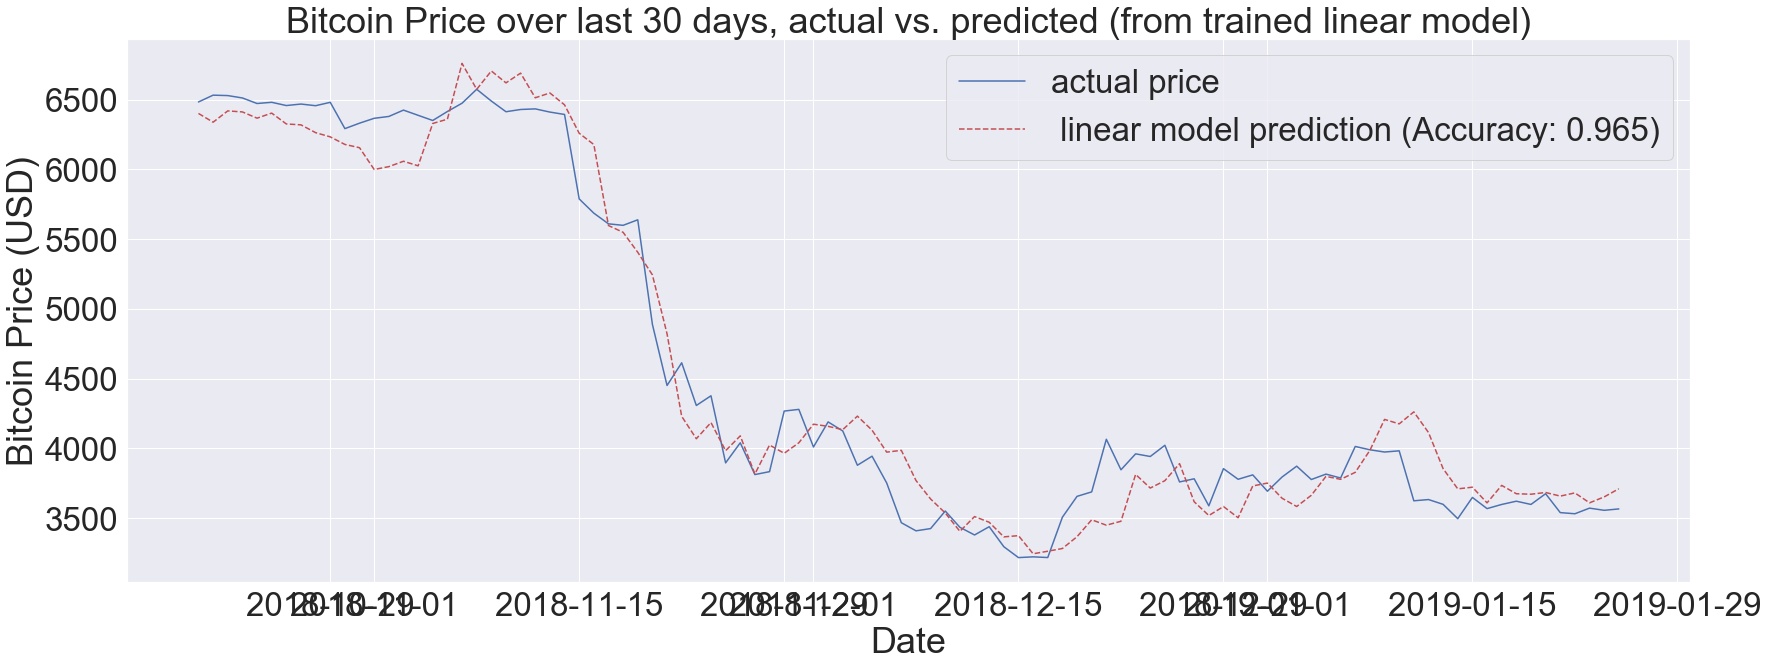

In [76]:
X_axis = df['date']
plt.figure(figsize = (28,10))
plt.plot(X_axis, y_train, label='actual price')
plt.plot(X_axis, y_pred, 'r--', label=' linear model prediction (Accuracy: {})'.format(round(score_linear, 3)))
plt.title('Bitcoin Price over last 30 days, actual vs. predicted (from trained linear model)')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.legend(loc='upper right')

In [77]:
score_linear

0.9646054246290175

In [78]:
m_linear.coef_

array([[ 3.72605045e+00,  7.60156110e+01,  4.96163397e+00,
         5.16244407e+01, -8.16720553e+03,  8.69596663e+03,
        -2.13740108e+04,  2.66036404e-03]])

In [79]:
testing_array = np.array(testing_data[features_to_model[2:]])
btc_prediction = m_linear.predict(testing_array)
btc_prediction

array([[3763.57085475],
       [3810.03371436]])

In [80]:
# ex = ExponentialSmoothing(y_train, damped=True, trend='add')

In [81]:
# result = ex.fit()

In [82]:
# ypred_ex = ex.predict(ex.params)

In [83]:
# xpred_ex = 

In [84]:
#btc2 = btc.copy()
#btc2.dropna()
#btc2['diff'] = btc2['price'] - btc2['day-1']
#btc2.head()
##btc[['price', 'day-1']].plot()
#btc2[['diff']].plot()